# Inference

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [17]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [18]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [19]:
from utils import set_pyplot_params
set_pyplot_params()

Whenever people compare Bayesian inference with conventional approaches, one of the questions that comes up most often is something like, "What about p-values?"
And one of the most common examples is the comparison of two groups to see if there is a difference in their means.

In classical statistical inference, the usual tool for this scenario is a [Student's *t*-test](https://en.wikipedia.org/wiki/Student%27s_t-test), and the result is a [p-value](https://en.wikipedia.org/wiki/P-value).
This process is an example of [null hypothesis significance testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing).

A Bayesian alternative is to compute the posterior distribution of the difference between the groups.
Then we can use that distribution to answer whatever questions we are interested in, including the most likely size of the difference, a credible interval that's likely to contain the true difference, the probability of superiority, or the probability that the difference exceeds some threshold.

To demonstrate this process, I'll solve a problem borrowed from a statistical textbook: evaluating the effect of an educational "treatment" compared to a control.

每当人们将贝叶斯推理与传统方法进行比较时，最常出现的问题之一就是“p 值怎么样？”
最常见的例子之一是比较两组，看看他们的平均值是否存在差异。

在经典统计推断中，这种场景的常用工具是 [Student's *t*-test](https://en.wikipedia.org/wiki/Student%27s_t-test)，结果是 [p-value ]（https://en.wikipedia.org/wiki/P-value）。
此过程是 [零假设显着性检验] (https://en.wikipedia.org/wiki/Statistical_hypothesis_testing) 的一个示例。

贝叶斯替代方法是计算组之间差异的后验分布。
然后我们可以使用该分布来回答我们感兴趣的任何问题，包括最可能的差异大小、可能包含真实差异的可信区间、优势概率或差异超过某个阈值的概率。

为了演示这个过程，我将解决从统计教科书中借来的一个问题：评估教育“治疗”与对照相比的效果。

## Improving Reading Ability

We'll use data from a [Ph.D. dissertation in educational psychology](https://docs.lib.purdue.edu/dissertations/AAI8807671/) written in 1987, which was used as an example in a [statistics textbook](https://books.google.com/books/about/Introduction_to_the_practice_of_statisti.html?id=pGBNhajABlUC) from 1989 and published on [DASL](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html), a web page that collects data stories.  

Here's the description from DASL:

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

The [dataset is available here](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html).

## 提高阅读能力

我们将使用来自 [Ph.D.教育心理学论文](https://docs.lib.purdue.edu/dissertations/AAI8807671/) 写于 1987 年，曾在[统计学教科书](https://books.google.com/ books/about/Introduction_to_the_practice_of_statisti.html?id=pGBNhajABlUC) 从 1989 年开始并发表在 [DASL](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles /DRPScores.html)，一个收集数据故事的网页。

以下是 DASL 的描述：

> 一位教育工作者进行了一项实验，以测试课堂上新的定向阅读活动是否会帮助小学生提高阅读能力的某些方面。她安排了一个由 21 名学生组成的三年级班级，为期 8 周，参加这些活动。一个由 23 名三年级学生组成的对照教室遵循相同的课程，但没有活动。在 8 周结束时，所有学生都参加了阅读能力 (DRP) 测试，该测试衡量治疗旨在提高的阅读能力方面。

[数据集在此处可用](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html)。

The following cell downloads the data.

In [20]:
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv')

I'll use Pandas to load the data into a `DataFrame`.

In [21]:
df2=pd.read_csv('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv', skiprows=21, delimiter='\t')

In [22]:
df2.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


In [23]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


The `Treatment` column indicates whether each student was in the treated or control group.
The `Response` is their score on the test.


I'll use `groupby` to separate the data for the `Treated` and `Control` groups:

In [24]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    print(name,group)
    responses[name] = group['Response']

Control    Treatment  Response
21   Control        42
22   Control        43
23   Control        55
24   Control        26
25   Control        62
26   Control        37
27   Control        33
28   Control        41
29   Control        19
30   Control        54
31   Control        20
32   Control        85
33   Control        46
34   Control        10
35   Control        17
36   Control        60
37   Control        53
38   Control        42
39   Control        37
40   Control        42
41   Control        55
42   Control        28
43   Control        48
Treated    Treatment  Response
0    Treated        24
1    Treated        43
2    Treated        58
3    Treated        71
4    Treated        43
5    Treated        49
6    Treated        61
7    Treated        44
8    Treated        67
9    Treated        49
10   Treated        53
11   Treated        56
12   Treated        59
13   Treated        52
14   Treated        62
15   Treated        54
16   Treated        57
17   Treated      

In [25]:
responses

{'Control': 21    42
 22    43
 23    55
 24    26
 25    62
 26    37
 27    33
 28    41
 29    19
 30    54
 31    20
 32    85
 33    46
 34    10
 35    17
 36    60
 37    53
 38    42
 39    37
 40    42
 41    55
 42    28
 43    48
 Name: Response, dtype: int64,
 'Treated': 0     24
 1     43
 2     58
 3     71
 4     43
 5     49
 6     61
 7     44
 8     67
 9     49
 10    53
 11    56
 12    59
 13    52
 14    62
 15    54
 16    57
 17    33
 18    46
 19    43
 20    57
 Name: Response, dtype: int64}

Here are CDFs of the scores for the two groups and summary statistics.

以下是两组分数的 CDF 和汇总统计数据。



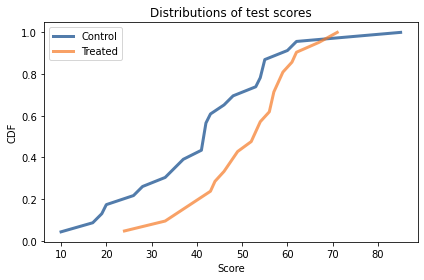

In [26]:
from empiricaldist import Cdf
from utils import decorate

for name, response in responses.items():
    cdf = Cdf.from_seq(response)
    cdf.plot(label=name)
    
decorate(xlabel='Score', 
         ylabel='CDF',
         title='Distributions of test scores')

There is overlap between the distributions, but it looks like the scores are higher in the treated group.
The distribution of scores is not exactly normal for either group, but it is close enough that the normal model is a reasonable choice.

So I'll assume that in the entire population of students (not just the ones in the experiment), the distribution of scores is well modeled by a normal distribution with unknown mean and standard deviation.
I'll use `mu` and `sigma` to denote these unknown parameters,
and we'll do a Bayesian update to estimate what they are.

分布之间存在重叠，但看起来治疗组的分数更高。
任何一组的分数分布都不完全正常，但它足够接近正常模型是一个合理的选择。

所以我假设在整个学生群体中（不仅仅是实验中的学生），分数的分布很好地由具有未知平均值和标准偏差的正态分布建模。
我将使用 `mu` 和 `sigma` 来表示这些未知参数，
我们将进行贝叶斯更新来估计它们是什么。

## Estimating Parameters

As always, we need a prior distribution for the parameters.
Since there are two parameters, it will be a joint distribution.
I'll construct it by choosing marginal distributions for each parameter and computing their outer product.

As a simple starting place, I'll assume that the prior distributions for `mu` and `sigma` are uniform.
The following function makes a `Pmf` object that represents a uniform distribution.

## 估计参数

与往常一样，我们需要参数的先验分布。
由于有两个参数，它将是一个联合分布。
我将通过为每个参数选择边际分布并计算它们的外积来构建它。

作为一个简单的起点，我假设 `mu` 和 `sigma` 的先验分布是一致的。
以下函数生成一个表示均匀分布的“Pmf”对象。

In [27]:
from empiricaldist import Pmf

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

`make_uniform` takes as parameters 

* An array of quantities, `qs`, and

* A string, `name`, which is assigned to the index so it appears when we display the `Pmf`.

Here's the prior distribution for `mu`:

`make_uniform` 作为参数

* 一个数量数组，`qs`，和

* 一个字符串，`name`，它被分配给索引，所以当我们显示 `Pmf` 时它会出现。

这是 `mu` 的先验分布：

In [28]:
import numpy as np

qs = np.linspace(20, 80, num=101)
prior_mu = make_uniform(qs, name='mean')

I chose the lower and upper bounds by trial and error.
I'll explain how when we look at the posterior distribution.

Here's the prior distribution for `sigma`:

我通过反复试验选择了下限和上限。
我将解释当我们查看后验分布时如何。

这是`sigma`的先验分布：

In [29]:
qs = np.linspace(5, 30, num=101)
prior_sigma = make_uniform(qs, name='std')

Now we can use `make_joint` to make the joint prior distribution.

现在我们可以使用`make_joint`来进行联合先验分布。

In [ ]:
## 在compare那章被定义
# def make_joint(pmf1, pmf2):
#     """Compute the outer product of two Pmfs."""
#     X, Y = np.meshgrid(pmf1, pmf2)
#     return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [30]:
from utils import make_joint

prior = make_joint(prior_mu, prior_sigma)

And we'll start by working with the data from the control group.

In [129]:
data = responses['Control']
data.shape
data

21    42
22    43
23    55
24    26
25    62
26    37
27    33
28    41
29    19
30    54
31    20
32    85
33    46
34    10
35    17
36    60
37    53
38    42
39    37
40    42
41    55
42    28
43    48
Name: Response, dtype: int64

In the next section we'll compute the likelihood of this data for each pair of parameters in the prior distribution.

在下一节中，我们将为先验分布中的每对参数计算该数据的似然性。

## Likelihood

We would like to know the probability of each score in the dataset for each hypothetical pair of values, `mu` and `sigma`.
I'll do that by making a 3-dimensional grid with values of `mu` on the first axis, values of `sigma` on the second axis, and the scores from the dataset on the third axis.

## 可能性

我们想知道数据集中每个假设值对“mu”和“sigma”的每个分数的概率。
我将通过制作一个 3 维网格来做到这一点，第一个轴的值为“mu”，第二个轴的值为“sigma”，第三个轴为数据集的分数。

In [126]:
prior.columns, prior.index

(Float64Index([             20.0,              20.6,              21.2,
                            21.8,              22.4,              23.0,
                            23.6,              24.2,              24.8,
                            25.4,
               ...
                            74.6, 75.19999999999999,              75.8,
                            76.4,              77.0,              77.6,
               78.19999999999999,              78.8,              79.4,
                            80.0],
              dtype='float64', name='mean', length=101),
 Float64Index([  5.0,  5.25,   5.5,  5.75,   6.0,  6.25,   6.5,  6.75,   7.0,
                7.25,
               ...
               27.75,  28.0, 28.25,  28.5, 28.75,  29.0, 29.25,  29.5, 29.75,
                30.0],
              dtype='float64', name='std', length=101))

In [130]:
data

21    42
22    43
23    55
24    26
25    62
26    37
27    33
28    41
29    19
30    54
31    20
32    85
33    46
34    10
35    17
36    60
37    53
38    42
39    37
40    42
41    55
42    28
43    48
Name: Response, dtype: int64

In [131]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, data)

mu_mesh.shape

(101, 101, 23)

Now we can use `norm.pdf` to compute the probability density of each score for each hypothetical pair of parameters.

现在我们可以使用“norm.pdf”来计算每个假设参数对的每个分数的概率密度。

In [132]:
from scipy.stats import norm

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

The result is a 3-D array.  To compute likelihoods, I'll multiply these densities along `axis=2`, which is the axis of the data:

结果是一个 3-D 数组。 为了计算可能性，我将沿 `axis=2` 乘以这些密度，这是数据的轴：

>prod返回给定轴上的数组元素的乘积。

In [34]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

The result is a 2-D array that contains the likelihood of the entire dataset for each hypothetical pair of parameters.

We can use this array to update the prior, like this:

结果是一个二维数组，其中包含每个假设参数对的整个数据集的可能性。

我们可以使用这个数组来更新先验，如下所示：

In [35]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

The result is a `DataFrame` that represents the joint posterior distribution.

The following function encapsulates these steps.

结果是一个表示联合后验分布的“DataFrame”。

以下函数封装了这些步骤。

In [36]:
def update_norm(prior, data):
    """Update the prior based on data."""
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)

    return posterior

Here are the updates for the control and treatment groups:

以下是对照组和治疗组的更新：

In [133]:
data

21    42
22    43
23    55
24    26
25    62
26    37
27    33
28    41
29    19
30    54
31    20
32    85
33    46
34    10
35    17
36    60
37    53
38    42
39    37
40    42
41    55
42    28
43    48
Name: Response, dtype: int64

In [37]:
data = responses['Control']
posterior_control = update_norm(prior, data)

In [38]:
data = responses['Treated']
posterior_treated = update_norm(prior, data)

And here's what they look like:

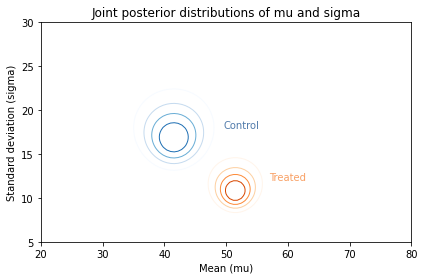

In [39]:
import matplotlib.pyplot as plt
from utils import plot_contour

plot_contour(posterior_control, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

Along the $x$-axis, it looks like the mean score for the treated group is higher.
Along the $y$-axis, it looks like the standard deviation for the treated group is lower.

If we think the treatment causes these differences, the data suggest that the treatment increases the mean of the scores and decreases their spread.
We can see these differences more clearly by looking at the marginal distributions for `mu` and `sigma`.

沿着 $x$ 轴，看起来治疗组的平均分数更高。
沿着 $y$ 轴，看起来治疗组的标准差较低。

如果我们认为治疗会导致这些差异，那么数据表明治疗会增加得分的平均值并降低它们的分布。
通过查看“mu”和“sigma”的边际分布，我们可以更清楚地看到这些差异。

## Posterior Marginal Distributions

I'll use `marginal`, which we saw in <<_MarginalDistributions>>, to extract the posterior marginal distributions for the population means.

## 后边际分布

我将使用我们在 <<_MarginalDistributions>> 中看到的 `marginal` 来提取总体均值的后边际分布。

In [40]:
from utils import marginal

pmf_mean_control = marginal(posterior_control, 0)
pmf_mean_treated = marginal(posterior_treated, 0)

Here's what they look like:

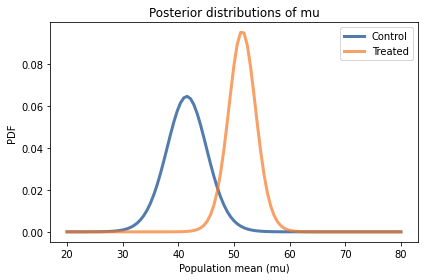

In [41]:
pmf_mean_control.plot(label='Control')
pmf_mean_treated.plot(label='Treated')

decorate(xlabel='Population mean (mu)', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

In both cases the posterior probabilities at the ends of the range are near zero, which means that the bounds we chose for the prior distribution are wide enough.

Comparing the marginal distributions for the two groups, it looks like the population mean in the treated group is higher.
We can use `prob_gt` to compute the probability of superiority:

在这两种情况下，范围末端的后验概率都接近于零，这意味着我们为先验分布选择的边界足够宽。

比较两组的边际分布，看起来治疗组的总体平均值更高。
我们可以使用 `prob_gt` 来计算优势概率：

In [42]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.9804790251873261

There is a 98% chance that the mean in the treated group is higher.

## Distribution of Differences

To quantify the magnitude of the difference between groups, we can use `sub_dist` to compute the distribution of the difference.

## 差异分布

为了量化组间差异的大小，我们可以使用 `sub_dist` 来计算差异的分布。

In [43]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

There are two things to be careful about when you use methods like `sub_dist`. 
The first is that the result usually contains more elements than the original `Pmf`.  
In this example, the original distributions have the same quantities, so the size increase is moderate.

当你使用像 `sub_dist` 这样的方法时，有两件事需要注意。
首先是结果通常包含比原始 `Pmf` 更多的元素。
在此示例中，原始分布具有相同的数量，因此大小增加适中。

In [44]:
len(pmf_mean_treated), len(pmf_mean_control), len(pmf_diff)

(101, 101, 879)

In the worst case, the size of the result can be the product of the sizes of the originals.

The other thing to be careful about is plotting the `Pmf`.
In this example, if we plot the distribution of differences, the result is pretty noisy.

在最坏的情况下，结果的大小可能是原件大小的乘积。

另一件需要注意的事情是绘制“Pmf”。
在这个例子中，如果我们绘制差异分布，结果会很嘈杂。

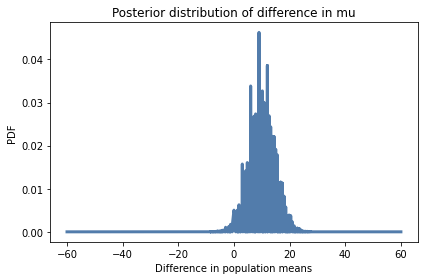

In [45]:
pmf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

There are two ways to work around that limitation.  One is to plot the CDF, which smooths out the noise:

有两种方法可以解决该限制。 一种是绘制 CDF，它可以消除噪声：

In [46]:
cdf_diff = pmf_diff.make_cdf()

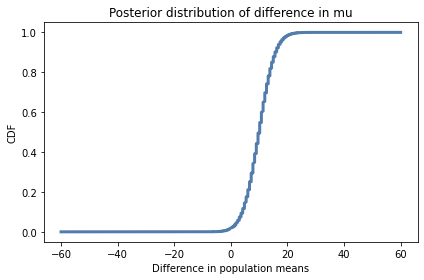

In [47]:
cdf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='CDF', 
         title='Posterior distribution of difference in mu')

The other option is to use kernel density estimation (KDE) to make a smooth approximation of the PDF on an equally-spaced grid, which is what this function does:

另一种选择是使用核密度估计 (KDE) 在等间距网格上对 PDF 进行平滑逼近，这就是该函数的作用：

In [48]:
from scipy.stats import gaussian_kde

def kde_from_pmf(pmf, n=101):
    """Make a kernel density estimate for a PMF."""
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`kde_from_pmf` takes as parameters a `Pmf` and the number of places to evaluate the KDE.

It uses `gaussian_kde`, which we saw in <<_KernelDensityEstimation>>, passing the probabilities from the `Pmf` as weights.
This makes the estimated densities higher where the probabilities in the `Pmf` are higher.

Here's what the kernel density estimate looks like for the `Pmf` of differences between the groups.

`kde_from_pmf` 将 `Pmf` 和评估 KDE 的位置数作为参数。

它使用我们在 <<_KernelDensityEstimation>> 中看到的 `gaussian_kde`，将来自 `Pmf` 的概率作为权重传递。
这使得在“Pmf”中的概率更高的地方估计密度更高。

这是组间差异的“Pmf”的内核密度估计值。

In [49]:
kde_diff = kde_from_pmf(pmf_diff)

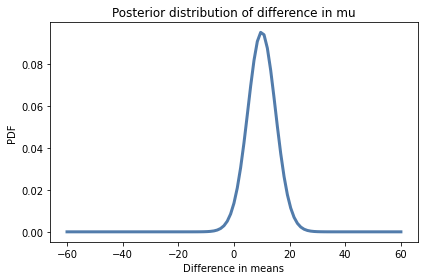

In [50]:
kde_diff.plot()

decorate(xlabel='Difference in means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

The mean of this distribution is almost 10 points on a test where the mean is around 45, so the effect of the treatment seems to be substantial.

在平均值约为 45 的测试中，该分布的平均值几乎为 10 分，因此处理的效果似乎很重要。


In [51]:
pmf_diff.mean()

9.954413088940852

We can use `credible_interval` to compute a 90% credible interval.

In [52]:
pmf_diff.credible_interval(0.9)

array([ 2.4, 17.4])

Based on this interval, we are pretty sure the treatment improves test scores by 2 to 17 points.

## Using Summary Statistics

In this example the dataset is not very big, so it doesn't take too long to compute the probability of every score under every hypothesis.
But the result is a 3-D array; for larger datasets, it might be too big to compute practically.

Also, with larger datasets the likelihoods get very small, sometimes so small that we can't compute them with floating-point arithmetic.
That's because we are computing the probability of a particular dataset; the number of possible datasets is astronomically big, so the probability of any of them is very small.

An alternative is to compute a summary of the dataset and compute the likelihood of the summary.
For example, if we compute the mean and standard deviation of the data, we can compute the likelihood of those summary statistics under each hypothesis.

As an example, suppose we know that the actual mean of the population, $\mu$,  is 42 and the actual standard deviation, $\sigma$, is 17.

## 使用汇总统计

在此示例中，数据集不是很大，因此计算每个假设下每个分数的概率不会花费太长时间。
但结果是一个 3-D 数组； 对于较大的数据集，实际计算可能太大。

此外，对于较大的数据集，可能性会变得非常小，有时甚至小到我们无法用浮点算法计算它们。
那是因为我们正在计算特定数据集的概率； 可能的数据集的数量是天文数字，因此其中任何一个的概率都非常小。

另一种方法是计算数据集的summary并计算summary的可能性。
例如，如果我们计算数据的均值和标准差，我们可以计算每个假设下这些汇总统计的可能性。

例如，假设我们知道总体的实际平均值 $\mu$ 是 42，而实际标准差 $\sigma$ 是 17。

In [53]:
mu = 42
sigma = 17

Now suppose we draw a sample from this distribution with sample size `n=20`, and compute the mean of the sample, which I'll call `m`, and the standard deviation of the sample, which I'll call `s`.

And suppose it turns out that:

现在假设我们从这个分布中抽取一个样本大小为“n=20”的样本，并计算样本的平均值，我称之为“m”，以及样本的标准差，我称之为“s” `。

假设结果是：

In [54]:
n = 20
m = 41
s = 18

The summary statistics, `m` and `s`, are not too far from the parameters $\mu$ and $\sigma$, so it seems like they are not too unlikely.

To compute their likelihood, we will take advantage of three results from mathematical statistics:

* Given $\mu$ and $\sigma$, the distribution of `m` is normal with parameters $\mu$ and $\sigma/\sqrt{n}$;

* The distribution of $s$ is more complicated, but if we compute the transform $t = n s^2 / \sigma^2$, the distribution of $t$ is chi-squared with parameter $n-1$; and

* According to [Basu's theorem](https://en.wikipedia.org/wiki/Basu%27s_theorem), `m` and `s` are independent.

So let's compute the likelihood of `m` and `s` given $\mu$ and $\sigma$.

First I'll create a `norm` object that represents the distribution of `m`.

汇总统计量 `m` 和 `s` 与参数 $\mu$ 和 $\sigma$ 相差不远，因此它们似乎不太可能。

为了计算它们的可能性，我们将利用数理统计的三个结果：

* 给定 $\mu$ 和 $\sigma$，`m` 的分布是正态分布的，参数为 $\mu$ 和 $\sigma/\sqrt{n}$；

* $s$ 的分布更复杂，但是如果我们计算变换 $t = n s^2 / \sigma^2$，$t$ 的分布是带有参数 $n-1$ 的卡方分布； 和

* 根据【巴苏定理】（https://en.wikipedia.org/wiki/Basu%27s_theorem），`m`和`s`是独立的。

所以让我们计算给定 $\mu$ 和 $\sigma$ 的 `m` 和 `s` 的可能性。

首先，我将创建一个代表“m”分布的“norm”对象。

In [55]:
dist_m = norm(mu, sigma/np.sqrt(n))

This is the "sampling distribution of the mean".
We can use it to compute the likelihood of the observed value of `m`, which is 41.

这就是“均值的抽样分布”。
我们可以使用它来计算“m”的观测值的似然性，即 41。

In [56]:
like1 = dist_m.pdf(m)
like1

0.10137915138497373

Now let's compute the likelihood of the observed value of `s`, which is 18.
First, we compute the transformed value `t`:

现在让我们计算 s 的观测值的可能性，即 18。
首先，我们计算转换后的值 `t`：

In [57]:
t = n * s**2 / sigma**2
t

22.422145328719722

Then we create a `chi2` object to represent the distribution of `t`:

然后我们创建一个 `chi2` 对象来表示 `t` 的分布：

In [58]:
from scipy.stats import chi2

dist_s = chi2(n-1)

Now we can compute the likelihood of `t`:
现在我们可以计算 `t` 的可能性：

In [59]:
like2 = dist_s.pdf(t)
like2

0.04736427909437004

Finally, because `m` and `s` are independent, their joint likelihood is the product of their likelihoods:

最后，因为 `m` 和 `s` 是独立的，所以它们的联合似然是它们似然的乘积：

In [60]:
like = like1 * like2
like

0.004801750420548287

Now we can compute the likelihood of the data for any values of $\mu$ and $\sigma$, which we'll use in the next section to do the update.

现在我们可以计算任何 $\mu$ 和 $\sigma$ 值的数据的可能性，我们将在下一节中使用它来进行更新。

## Update with Summary Statistics

Now we're ready to do an update.
I'll compute summary statistics for the two groups.

## 使用汇总统计更新

现在我们准备进行更新。
我将计算这两组的汇总统计数据。

In [61]:
summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
    
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

The result is a dictionary that maps from group name to a tuple that contains the sample size, `n`, the sample mean, `m`, and the sample standard deviation `s`, for each group.

I'll demonstrate the update with the summary statistics from the control group.

结果是一个字典，它从组名映射到一个元组，其中包含每个组的样本大小“n”、样本均值“m”和样本标准差“s”。

我将使用来自对照组的汇总统计数据来演示更新。

In [62]:
n, m, s = summary['Control']

I'll make a mesh with hypothetical values of `mu` on the `x` axis and values of `sigma` on the `y` axis.

我将用 `x` 轴上的 `mu` 假设值和 `y` 轴上的 `sigma` 值制作一个网格。

In [63]:
mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

(101, 101)

In [135]:
mus

array([[20. , 20.6, 21.2, ..., 78.8, 79.4, 80. ],
       [20. , 20.6, 21.2, ..., 78.8, 79.4, 80. ],
       [20. , 20.6, 21.2, ..., 78.8, 79.4, 80. ],
       ...,
       [20. , 20.6, 21.2, ..., 78.8, 79.4, 80. ],
       [20. , 20.6, 21.2, ..., 78.8, 79.4, 80. ],
       [20. , 20.6, 21.2, ..., 78.8, 79.4, 80. ]])

Now we can compute the likelihood of seeing the sample mean, `m`, for each pair of parameters.

现在我们可以计算每对参数看到样本均值“m”的可能性。

In [64]:
like1 = norm(mus, sigmas/np.sqrt(n)).pdf(m)
like1.shape

(101, 101)

And we can compute the likelihood of the sample standard deviation, `s`, for each pair of parameters.

我们可以计算每对参数的样本标准偏差“s”的可能性。

In [65]:
ts = n * s**2 / sigmas**2
like2 = chi2(n-1).pdf(ts)
like2.shape

(101, 101)

Finally, we can do the update with both likelihoods:

最后，我们可以使用两种可能性进行更新：

In [66]:
posterior_control2 = prior * like1 * like2
normalize(posterior_control2)

0.00030965351017402847

To compute the posterior distribution for the treatment group, I'll put the previous steps in a function:

为了计算治疗组的后验分布，我将前面的步骤放在一个函数中：

In [67]:
def update_norm_summary(prior, data):
    """Update a normal distribution using summary statistics."""
    n, m, s = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index)
    
    like1 = norm(mu_mesh, sigma_mesh/np.sqrt(n)).pdf(m)
    like2 = chi2(n-1).pdf(n * s**2 / sigma_mesh**2)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    
    return posterior

Here's the update for the treatment group:

In [68]:
data = summary['Treated']
posterior_treated2 = update_norm_summary(prior, data)

And here are the results.

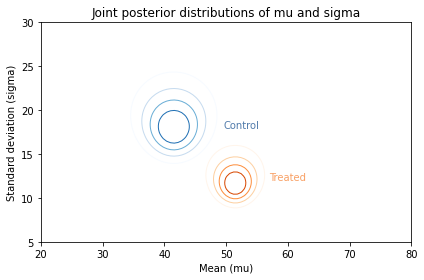

In [69]:
plot_contour(posterior_control2, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated2, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

Visually, these posterior joint distributions are similar to the ones we computed using the entire dataset, not just the summary statistics.
But they are not exactly the same, as we can see by comparing the marginal distributions.

从视觉上看，这些后联合分布类似于我们使用整个数据集计算的那些，而不仅仅是汇总统计数据。
但它们并不完全相同，正如我们通过比较边际分布所看到的那样。

## Comparing Marginals

Again, let's extract the marginal posterior distributions.

## 比较边际

同样，让我们提取边缘后验分布。

In [ ]:

# def marginal(joint, axis):
#     """Compute a marginal distribution.

#     axis=0 returns the marginal distribution of the first variable
#     axis=1 returns the marginal distribution of the second variable

#     joint: DataFrame representing a joint distribution
#     axis: int axis to sum along

#     returns: Pmf
#     """
#     return Pmf(joint.sum(axis=axis))

In [137]:
posterior_control2.shape

(101, 101)

In [141]:
B = np.array([[1, 2], [3, 4], [5, 6]])	# 二维
print(B.shape)
	# 按列求和
print(B.sum(axis=0))

(3, 2)
[ 9 12]


In [70]:
from utils import marginal

pmf_mean_control2 = marginal(posterior_control2, 0)
pmf_mean_treated2 = marginal(posterior_treated2, 0)

In [136]:
pmf_mean_control2

,probs
mean,
20.0,2.406972e-06
20.6,3.668591e-06
21.2,5.562137e-06
21.8,8.389873e-06
22.4,1.259191e-05
...,...
77.6,1.200271e-11
78.2,6.606296e-12
78.8,3.606810e-12


And compare them to results we got using the entire dataset (the dashed lines).

并将它们与我们使用整个数据集（虚线）获得的结果进行比较。

In [142]:
pmf_mean_control

,probs
mean,
20.0,9.483406e-07
20.6,1.474243e-06
21.2,2.282793e-06
21.8,3.521553e-06
22.4,5.413024e-06
...,...
77.6,3.781537e-12
78.2,2.073921e-12
78.8,1.128473e-12


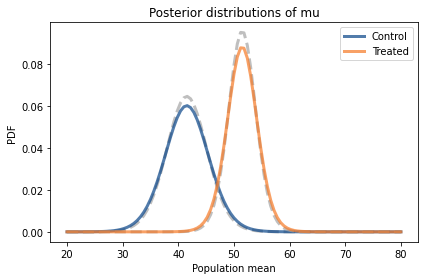

In [134]:
pmf_mean_control.plot(color='C5', ls='--')
pmf_mean_control2.plot(label='Control')
pmf_mean_treated.plot(color='C5', ls='--')
pmf_mean_treated2.plot(label='Treated')

decorate(xlabel='Population mean', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

The posterior distributions based on summary statistics are similar to the posteriors we computed using the entire dataset, but in both cases they are shorter and a little wider.

That's because the update with summary statistics is based on the implicit assumption that the distribution of the data is normal.
But it's not; as a result, when we replace the dataset with the summary statistics, we lose some information about the true distribution of the data.
With less information, we are less certain about the parameters.

基于汇总统计的后验分布类似于我们使用整个数据集计算的后验分布，但在这两种情况下它们都更短且更宽一些。

这是因为汇总统计的更新是基于隐含的假设，即数据的分布是正常的。
但事实并非如此； 因此，当我们用汇总统计数据替换数据集时，我们会丢失一些关于数据真实分布的信息。
由于信息较少，我们对参数的确定性较低。

## Proof By Simulation

The update with summary statistics is based on theoretical distributions, and it seems to work, but I think it is useful to test theories like this, for a few reasons:

* It confirms that our understanding of the theory is correct,

* It confirms that the conditions where we apply the theory are conditions where the theory holds, 

* It confirms that the implementation details are correct.  For many distributions, there is more than one way to specify the parameters.  If you use the wrong specification, this kind of testing will help you catch the error.

In this section I'll use simulations to show that the distribution of the sample mean and standard deviation is as I claimed.
But if you want to take my word for it, you can skip this section and the next.

## 模拟证明

摘要统计的更新是基于理论分布的，它似乎有效，但我认为测试这样的理论很有用，原因如下：

* 证实我们对理论的理解是正确的，

* 它证实了我们应用该理论的条件是该理论成立的条件，

* 它确认实施细节是正确的。 对于许多分布，指定参数的方法不止一种。 如果您使用了错误的规范，这种测试将帮助您发现错误。

在本节中，我将使用模拟来证明样本均值和标准差的分布与我声称的一样。
但是，如果您想相信我的话，您可以跳过本节和下一节。

Let's suppose that we know the actual mean and standard deviation of the population:

假设我们知道总体的实际均值和标准差：

In [72]:
mu = 42
sigma = 17

I'll create a `norm` object to represent this distribution.

我将创建一个“规范”对象来表示这个分布。

In [73]:
dist = norm(mu, sigma)

`norm` provides `rvs`, which generates random values from the distribution.
We can use it to simulate 1000 samples, each with sample size `n=20`.


`norm` 提供了 `rvs`，它从分布中生成随机值。
我们可以用它来模拟 1000 个样本，每个样本大小为“n=20”。

In [74]:
n = 20
samples = dist.rvs((1000, n))
samples.shape

(1000, 20)

The result is an array with 1000 rows, each containing a sample or 20 simulated test scores.

If we compute the mean of each row, the result is an array that contains 1000 sample means; that is, each value is the mean of a sample with `n=20`.

结果是一个包含 1000 行的数组，每行包含一个样本或 20 个模拟测试分数。

如果我们计算每一行的平均值，结果是一个包含 1000 个样本平均值的数组； 也就是说，每个值都是“n=20”样本的平均值。

In [75]:
sample_means = samples.mean(axis=1)
sample_means.shape

(1000,)

Now, let's compare the distribution of these means to `dist_m`.
I'll use `pmf_from_dist` to make a discrete approximation of `dist_m`:

现在，让我们将这些均值的分布与 `dist_m` 进行比较。
我将使用 `pmf_from_dist` 对 `dist_m` 进行离散近似：

In [76]:
def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`pmf_from_dist` takes an object representing a continuous distribution, evaluates its probability density function at equally space points between `low` and `high`, and returns a normalized `Pmf` that approximates the distribution.

I'll use it to evaluate `dist_m` over a range of six standard deviations.

`pmf_from_dist` 获取一个表示连续分布的对象，在 `low` 和 `high` 之间的相等空间点处评估其概率密度函数，并返回一个近似分布的归一化 `Pmf`。

我将使用它在六个标准差的范围内评估“dist_m”。

In [77]:
low = dist_m.mean() - dist_m.std() * 3
high = dist_m.mean() + dist_m.std() * 3

pmf_m = pmf_from_dist(dist_m, low, high)

Now let's compare this theoretical distribution to the means of the samples.
I'll use `kde_from_sample` to estimate their distribution and evaluate it in the same locations as `pmf_m`.

现在让我们将这个理论分布与样本的均值进行比较。
我将使用 `kde_from_sample` 来估计它们的分布并在与 `pmf_m` 相同的位置进行评估。

In [78]:
from utils import kde_from_sample

qs = pmf_m.qs
pmf_sample_means = kde_from_sample(sample_means, qs)

The following figure shows the two distributions.

下图显示了两种分布。

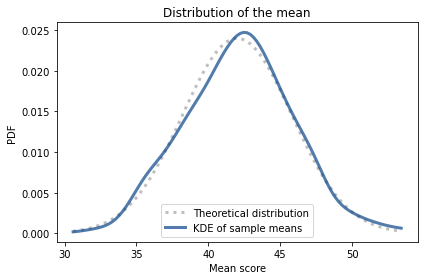

In [79]:
pmf_m.plot(label='Theoretical distribution',
           ls=':', color='C5')
pmf_sample_means.plot(label='KDE of sample means')

decorate(xlabel='Mean score',
         ylabel='PDF',
         title='Distribution of the mean')

The theoretical distribution and the distribution of sample means are in accord.

理论分布与样本均值分布一致。

## Checking Standard Deviation

Let's also check that the standard deviations follow the distribution we expect.
First I'll compute the standard deviation for each of the 1000 samples.
## 检查标准偏差

我们还要检查标准差是否符合我们预期的分布。
首先，我将计算 1000 个样本中每个样本的标准偏差。

In [80]:
sample_stds = samples.std(axis=1)
sample_stds.shape

(1000,)

Now we'll compute the transformed values, $t = n s^2 / \sigma^2$.

现在我们将计算转换后的值，$t = n s^2 / \sigma^2$。

In [81]:
transformed = n * sample_stds**2 / sigma**2

We expect the transformed values to follow a chi-square distribution with parameter $n-1$.
SciPy provides `chi2`, which we can use to represent this distribution.

我们期望转换后的值遵循参数 $n-1$ 的卡方分布。
SciPy 提供了 `chi2`，我们可以用它来表示这个分布。

In [82]:
from scipy.stats import chi2

dist_s = chi2(n-1)

We can use `pmf_from_dist` again to make a discrete approximation.

我们可以再次使用 pmf_from_dist 来进行离散近似。

In [83]:
low = 0
high = dist_s.mean() + dist_s.std() * 4

pmf_s = pmf_from_dist(dist_s, low, high)

And we'll use `kde_from_sample` to estimate the distribution of the sample standard deviations.

我们将使用 `kde_from_sample` 来估计样本标准差的分布。

In [84]:
qs = pmf_s.qs
pmf_sample_stds = kde_from_sample(transformed, qs)

Now we can compare the theoretical distribution to the distribution of the standard deviations.

现在我们可以将理论分布与标准偏差的分布进行比较。

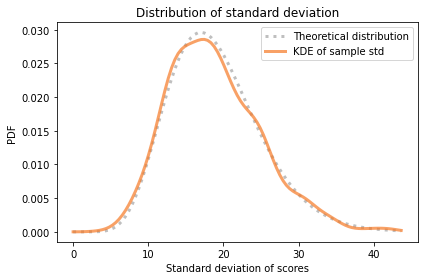

In [85]:
pmf_s.plot(label='Theoretical distribution',
           ls=':', color='C5')
pmf_sample_stds.plot(label='KDE of sample std',
                     color='C1')

decorate(xlabel='Standard deviation of scores',
         ylabel='PDF',
         title='Distribution of standard deviation')

The distribution of transformed standard deviations agrees with the theoretical distribution.

Finally, to confirm that the sample means and standard deviations are independent, I'll compute their coefficient of correlation:

转换后的标准差分布与理论分布一致。

最后，为了确认样本均值和标准差是独立的，我将计算它们的相关系数：

In [86]:
np.corrcoef(sample_means, sample_stds)[0][1]

-0.06664107308497566

Their correlation is near zero, which is consistent with their being independent.

So the simulations confirm the theoretical results we used to do the update with summary statistics.

它们的相关性接近于零，这与它们的独立性一致。

因此，模拟证实了我们使用汇总统计数据进行更新的理论结果。

We can also use `kdeplot` from Seaborn to see what their joint distribution looks like.

我们还可以使用 Seaborn 的 `kdeplot` 来查看它们的联合分布情况。

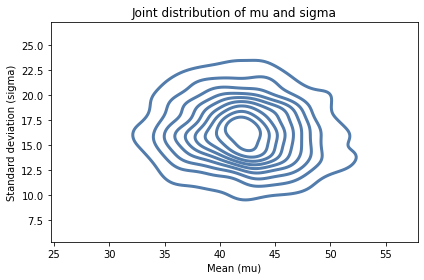

In [87]:
import seaborn as sns

sns.kdeplot(x=sample_means, y=sample_stds)

decorate(xlabel='Mean (mu)',
         ylabel='Standard deviation (sigma)',
         title='Joint distribution of mu and sigma')

It looks like the axes of the ellipses are aligned with the axes, which indicates that the variables are independent.

看起来椭圆的轴与轴对齐，这表明变量是独立的。

## Summary

In this chapter we used a joint distribution to represent prior probabilities for the parameters of a normal distribution, `mu` and `sigma`.
And we updated that distribution two ways: first using the entire dataset and the normal PDF; then using summary statistics, the normal PDF, and the chi-square PDF.
Using summary statistics is computationally more efficient, but it loses some information in the process.

Normal distributions appear in many domains, so the methods in this chapter are broadly applicable.  The exercises at the end of the chapter will give you a chance to apply them.

## 概括

在本章中，我们使用联合分布来表示正态分布参数“mu”和“sigma”的先验概率。
我们以两种方式更新了该分布：首先使用整个数据集和普通 PDF； 然后使用汇总统计、普通 PDF 和卡方 PDF。
使用汇总统计在计算上更有效，但在此过程中会丢失一些信息。

正态分布出现在许多领域，因此本章中的方法具有广泛的适用性。 本章末尾的练习将使您有机会应用它们。

## Exercises

**Exercise:** Looking again at the posterior joint distribution of `mu` and `sigma`, it seems like the standard deviation of the treated group might be lower; if so, that would suggest that the treatment is more effective for students with lower scores.

But before we speculate too much, we should estimate the size of the difference and see whether it might actually be 0.

Extract the marginal posterior distributions of `sigma` for the two groups.
What is the probability that the standard deviation is higher in the control group?

Compute the distribution of the difference in `sigma` between the two groups.  What is the mean of this difference?  What is the 90% credible interval?
**练习：** 再看`mu`和`sigma`的后联合分布，似乎治疗组的标准差可能更低； 如果是这样，那就表明这种治疗对分数较低的学生更有效。

但在我们过多推测之前，我们应该估计一下差异的大小，看看它是否真的可能为 0。

提取两组的“sigma”的边际后验分布。
对照组中标准差较高的概率是多少？

计算两组之间“sigma”差异的分布。 这种差异的意义是什么？ 90%可信区间是多少？

In [88]:
# Solution goes here

In [89]:
# Solution goes here

In [90]:
# Solution goes here

In [91]:
# Solution goes here

In [92]:
# Solution goes here

In [93]:
# Solution goes here

In [94]:
# Solution goes here

**Exercise:** An [effect size](http://en.wikipedia.org/wiki/Effect_size) is a statistic intended to quantify the magnitude of a phenomenon.
If the phenomenon is a difference in means between two groups, a common way to quantify it is Cohen's effect size, denoted $d$.

If the parameters for Group 1 are $(\mu_1, \sigma_1)$, and the
parameters for Group 2 are $(\mu_2, \sigma_2)$, Cohen's
effect size is

$$ d = \frac{\mu_1 - \mu_2}{(\sigma_1 + \sigma_2)/2} $$

Use the joint posterior distributions for the two groups to compute the posterior distribution for Cohen's effect size.

If we try enumerate all pairs from the two distributions, it takes too
long so we'll use random sampling.

The following function takes a joint posterior distribution and returns a sample of pairs.
It uses some features we have not seen yet, but you can ignore the details for now.

In [95]:
def sample_joint(joint, size):
    """Draw a sample from a joint distribution.
    
    joint: DataFrame representing a joint distribution
    size: sample size
    """
    pmf = Pmf(joint.transpose().stack())
    return pmf.choice(size)

Here's how we can use it to sample pairs from the posterior distributions for the two groups.

In [96]:
sample_treated = sample_joint(posterior_treated, 1000)
sample_treated.shape

(1000,)

In [97]:
sample_control = sample_joint(posterior_control, 1000)
sample_control.shape

(1000,)

The result is an array of tuples, where each tuple contains a possible pair of values for $\mu$ and $\sigma$.
Now you can loop through the samples, compute the Cohen effect size for each, and estimate the distribution of effect sizes.

In [98]:
# Solution goes here

In [99]:
# Solution goes here

In [100]:
# Solution goes here

In [101]:
# Solution goes here

In [102]:
# Solution goes here

In [103]:
# Solution goes here

**Exercise:** This exercise is inspired by [a question that appeared on Reddit](https://www.reddit.com/r/statistics/comments/hcvl2j/q_reverse_empirical_distribution_rule_question/).

An instructor announces the results of an exam like this, "The average score on this exam was 81.  Out of 25 students, 5 got more than 90, and I am happy to report that no one failed (got less than 60)."

Based on this information, what do you think the standard deviation of scores was?

You can assume that the distribution of scores is approximately normal.  And let's assume that the sample mean, 81, is actually the population mean, so we only have to estimate `sigma`.

Hint: To compute the probability of a score greater than 90, you can use `norm.sf`, which computes the survival function, also known as the complementary CDF, or `1 - cdf(x)`.

In [104]:
# Solution goes here

In [105]:
# Solution goes here

In [106]:
# Solution goes here

In [107]:
# Solution goes here

In [108]:
# Solution goes here

In [109]:
# Solution goes here

In [110]:
# Solution goes here

In [111]:
# Solution goes here

In [112]:
# Solution goes here

In [113]:
# Solution goes here

In [114]:
# Solution goes here

In [115]:
# Solution goes here

**Exercise:** The [Variability Hypothesis](http://en.wikipedia.org/wiki/Variability_hypothesis) is the observation that many physical traits are more variable among males than among females, in many species. 

It has been a subject of controversy since the early 1800s, which suggests an exercise we can use to practice the methods in this chapter.  Let's look at the distribution of heights for men and women in the U.S. and see who is more variable.

I used 2018 data from the CDC's [Behavioral Risk Factor Surveillance System](https://www.cdc.gov/brfss/annual_data/annual_2018.html) (BRFSS), which includes self-reported heights from 154 407 men and 254 722 women. 

Here's what I found:

* The average height for men is 178 cm; the average height for women is 163 cm. So men are taller on average; no surprise there.

* For men the standard deviation is 8.27 cm; for women it is 7.75 cm. So in absolute terms, men's heights are more variable.

But to compare variability between groups, it is more meaningful to use the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) (CV), which is the standard deviation divided by the mean. It is a dimensionless measure of variability relative to scale. 

For men CV is 0.0465; for women it is 0.0475.
The coefficient of variation is higher for women, so this dataset provides evidence against the Variability Hypothesis. But we can use Bayesian methods to make that conclusion more precise.

Use these summary statistics to compute the posterior distribution of `mu` and `sigma` for the distributions of male and female height.
Use `Pmf.div_dist` to compute posterior distributions of CV.
Based on this dataset and the assumption that the distribution of height is normal, what is the probability that the coefficient of variation is higher for men?
What is the most likely ratio of the CVs and what is the 90% credible interval for that ratio?

Hint: Use different prior distributions for the two groups, and chose them so they cover all parameters with non-negligible probability.

Also, you might find this function helpful:

In [116]:
def get_posterior_cv(joint):
    """Get the posterior distribution of CV.
    
    joint: joint distribution of mu and sigma
    
    returns: Pmf representing the smoothed posterior distribution
    """
    pmf_mu = marginal(joint, 0)
    pmf_sigma = marginal(joint, 1)
    pmf_cv = Pmf.div_dist(pmf_sigma, pmf_mu)
    return kde_from_pmf(pmf_cv)

In [117]:
# Solution goes here

In [118]:
# Solution goes here

In [119]:
# Solution goes here

In [120]:
# Solution goes here

In [121]:
# Solution goes here

In [122]:
# Solution goes here

In [123]:
# Solution goes here

In [124]:
# Solution goes here

In [125]:
# Solution goes here